In [3]:
p = parks.Parks()
p.get_all_parkunits()

['acad',
 'arch',
 'badl',
 'bibe',
 'bisc',
 'blca',
 'brca',
 'cany',
 'care',
 'cave',
 'chis',
 'cong',
 'crla',
 'cuva',
 'dena',
 'deva',
 'drto',
 'ever',
 'gaar',
 'glac',
 'glba',
 'grba',
 'grca',
 'grsa',
 'grsm',
 'grte',
 'gumo',
 'hale',
 'havo',
 'hosp',
 'indu',
 'isro',
 'jeff',
 'jotr',
 'katm',
 'kefj',
 'kica',
 'kova',
 'lacl',
 'lavo',
 'maca',
 'meve',
 'mora',
 'noca',
 'npsa',
 'olym',
 'pefo',
 'pinn',
 'redw',
 'romo',
 'sagu',
 'sequ',
 'shen',
 'thro',
 'viis',
 'voya',
 'whsa',
 'wica',
 'wrst',
 'yell',
 'yose',
 'zion']

In [1]:
import sys, os
import folium
sys.path.append('..')
import flickrapi
import nationalparks.clusters as clusters
import nationalparks.secrets as secrets
import nationalparks.parks as parks
import scrapper.fetch_images as fetch_images
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_samples, silhouette_score
import geopandas as gpd
from update_database import update_clusters

In [8]:
parkunit = 'yell'
my_park = parks.Park(parkunit)

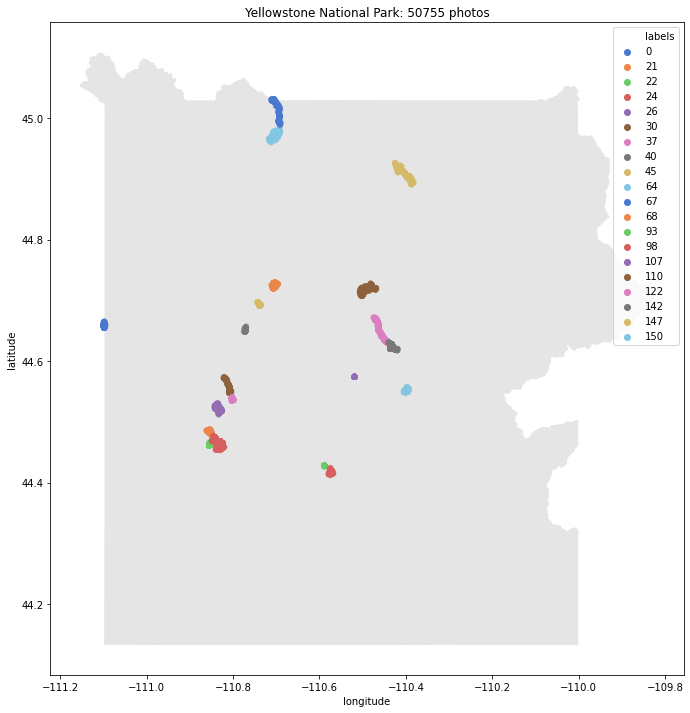

In [11]:
my_park.plot_all_photos();